In [42]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt  # This is for matrix operations
import arviz as az
import matplotlib.pyplot as plt

# Set some sensible defaults
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [43]:
# --- 1. Define Simulation Parameters ---
N_persons = 200
I_items = 30
K_dims = 3

# --- 2. Generate True Parameters (WITH ANCHORS) ---

# Person Abilities (theta)
true_theta = np.random.normal(0, 1, size=(N_persons, K_dims))

# Item Intercepts (d)
true_d = np.random.normal(0, 2, size=I_items) 

# Item Magnitudes (g)
true_g = np.random.lognormal(0, 0.5, size=I_items)

# Item Directions (w)
# --- THIS IS THE NEW PART ---
true_w = np.zeros((I_items, K_dims))

# Anchor 1 (Item 0): Loads on Dim 1
true_w[0] = [1.0, 0.0, 0.0]

# Anchor 2 (Item 1): Loads on Dim 2
true_w[1] = [0.0, 1.0, 0.0]

# Anchor 3 (Item 2): Loads on Dim 3
true_w[2] = [0.0, 0.0, 1.0]

# All other items (3 to 29) get a sparse prior
alpha_sparse = np.array([0.5] * K_dims)
true_w[3:] = np.random.dirichlet(alpha_sparse, size=(I_items - K_dims))
# --- END NEW PART ---


# --- 3. Calculate the Linear Predictor (L) ---
dot_prod = np.dot(true_theta, true_w.T)  # Shape (N, I)
L_true = true_d + true_g * dot_prod      

# --- 4. Calculate Probabilities and Simulate Responses (Y) ---
P_true = 1 / (1 + np.exp(-L_true))
Y_data = np.random.binomial(1, P_true)

print("--- Ground Truth Anchors ---")
print(f"True 'w' for Item 0: {true_w[0]}")
print(f"True 'w' for Item 1: {true_w[1]}")
print(f"True 'w' for Item 2: {true_w[2]}")
print(f"True 'w' for Item 3: {np.round(true_w[3], 2)}")

--- Ground Truth Anchors ---
True 'w' for Item 0: [1. 0. 0.]
True 'w' for Item 1: [0. 1. 0.]
True 'w' for Item 2: [0. 0. 1.]
True 'w' for Item 3: [0.21 0.46 0.33]


In [44]:
# --- Define the Anchor Priors ---
# We use a "soft" anchor. 10.0 is strong, but not 100% rigid.
alpha_anchor_1 = [10.0, 0.5, 0.5]
alpha_anchor_2 = [0.5, 10.0, 0.5]
alpha_anchor_3 = [0.5, 0.5, 10.0]
alpha_sparse = [0.5, 0.5, 0.5]

# Build the (I_items, K_dims) alpha prior matrix
alpha_prior_matrix = np.tile(alpha_sparse, (I_items, 1)) # Start with all sparse
alpha_prior_matrix[0] = alpha_anchor_1
alpha_prior_matrix[1] = alpha_anchor_2
alpha_prior_matrix[2] = alpha_anchor_3

print("--- Prior Alpha Matrix (first 4 rows) ---")
print(alpha_prior_matrix[:4])

with pm.Model(coords=coords) as dirichlet_mirt_anchored:
    
    Y_obs = pm.Data("Y_obs", Y_data, dims=("person", "item"))

    # --- Parameters (Non-Centered, same as before) ---
    theta_raw = pm.Normal("theta_raw", mu=0, sigma=1, dims=("person", "dim"))
    theta = pm.Deterministic("theta", theta_raw)

    d_raw = pm.Normal("d_raw", mu=0, sigma=1, dims="item")
    d = pm.Deterministic("d", 0 + 5 * d_raw)
    
    log_g_raw = pm.Normal("log_g_raw", mu=0, sigma=1, dims="item")
    g = pm.Deterministic("g", pt.exp(log_g_raw))
    
    # --- THIS IS THE CORRECTED 'w' PRIOR ---
    # We pass the *entire matrix* as the 'a' parameter.
    # PyMC is smart enough to apply the ith row of 'a'
    # as the prior for the ith row of 'w'.
    w = pm.Dirichlet("w", a=alpha_prior_matrix, dims=("item", "dim"))
    # --- END CORRECTION ---

    
    # --- Linear Predictor & Likelihood (same as before) ---
    dot_prod = pt.dot(theta, w.T)
    L = pm.Deterministic("L", d + g * dot_prod)
    Y_hat = pm.Bernoulli("Y_hat", logit_p=L, observed=Y_obs, dims=("person", "item"))

--- Prior Alpha Matrix (first 4 rows) ---
[[10.   0.5  0.5]
 [ 0.5 10.   0.5]
 [ 0.5  0.5 10. ]
 [ 0.5  0.5  0.5]]


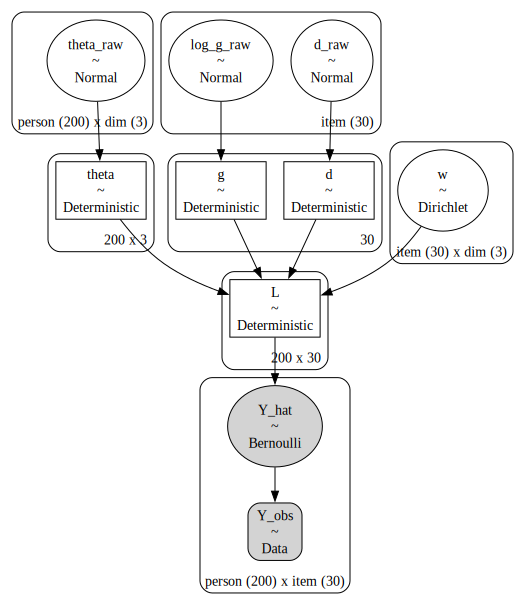

In [45]:
# Let's look at the model structure
pm.model_to_graphviz(dirichlet_mirt_anchored)

In [46]:
with dirichlet_mirt_anchored:
    # 1. Using the reparameterized model
    # 2. Increasing target_accept to 0.95
    # 3. Using a more standard 2000 draws
    trace = pm.sample(2000, tune=1500, chains=4, cores=4, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_raw, d_raw, log_g_raw, w]


Output()

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 68 seconds.


In [47]:
# We'll check the main item parameters
var_names = ["d", "g", "w"]
summary = az.summary(trace, var_names=var_names)
print(summary)

# Check for any r_hat > 1.01
if (summary["r_hat"] > 1.01).any():
    print("\nWARNING: Poor convergence detected! Check r_hat values.")
else:
    print("\nSUCCESS: All r_hat values look good. Convergence achieved.")

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
d[0]     -1.012  0.919  -2.627    0.174      0.034    0.061    1060.0   
d[1]      0.034  0.655  -1.276    1.116      0.025    0.064    1588.0   
d[2]      0.152  0.191  -0.177    0.496      0.005    0.014    3865.0   
d[3]     -0.592  0.179  -0.921   -0.247      0.002    0.002    6152.0   
d[4]     -0.496  0.186  -0.847   -0.156      0.003    0.004    5625.0   
...         ...    ...     ...      ...        ...      ...       ...   
w[28, 1]  0.497  0.251   0.000    0.898      0.004    0.003    3425.0   
w[28, 2]  0.269  0.226   0.000    0.679      0.003    0.002    4180.0   
w[29, 0]  0.125  0.135   0.000    0.371      0.002    0.002    3682.0   
w[29, 1]  0.540  0.235   0.147    1.000      0.005    0.003    2574.0   
w[29, 2]  0.335  0.230   0.000    0.718      0.005    0.002    2455.0   

          ess_tail  r_hat  
d[0]         862.0    1.0  
d[1]         887.0    1.0  
d[2]        1950.0    1.0  
d[3]       

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_50965/2499437061.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


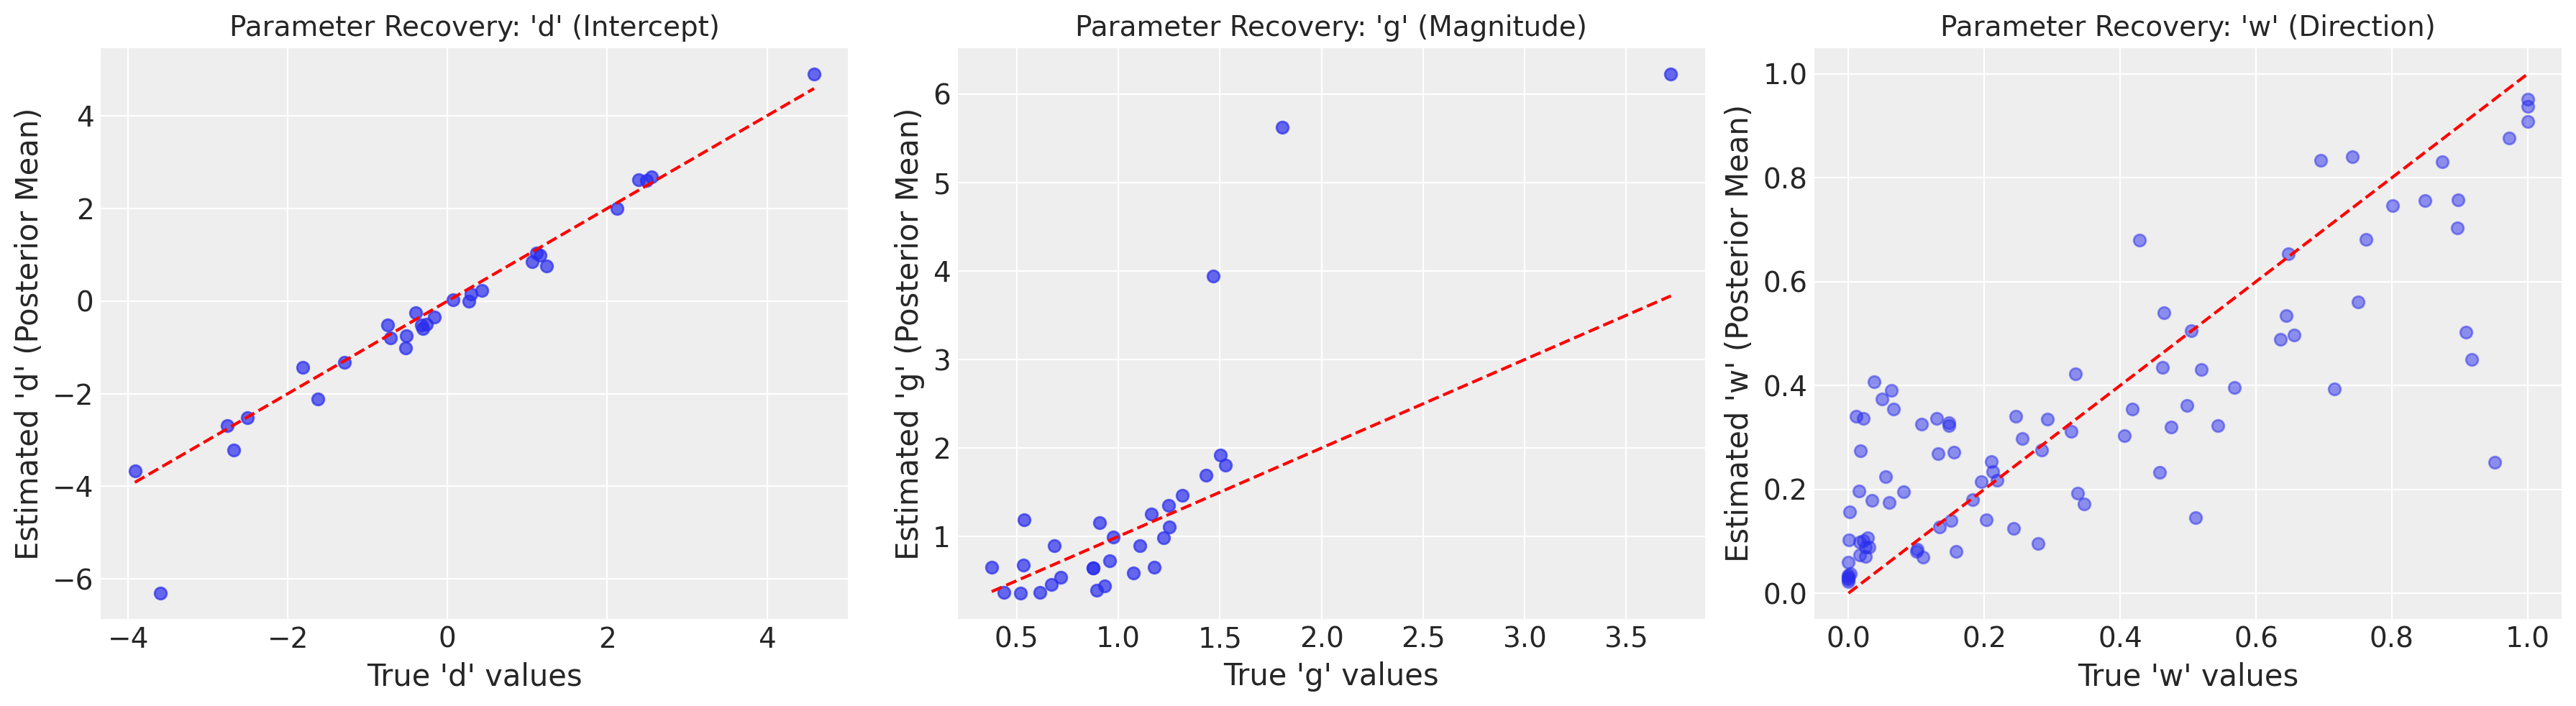

In [48]:
# Extract the posterior means from the summary
est_d = summary.loc[summary.index.str.startswith('d'), 'mean']
est_g = summary.loc[summary.index.str.startswith('g'), 'mean']
est_w = summary.loc[summary.index.str.startswith('w'), 'mean'].values.reshape(I_items, K_dims)

# Create a 3-panel plot
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 'd' (Intercept) ---
ax[0].scatter(true_d, est_d, alpha=0.7)
ax[0].plot([min(true_d), max(true_d)], [min(true_d), max(true_d)], 'r--')
ax[0].set_title("Parameter Recovery: 'd' (Intercept)", fontsize=14)
ax[0].set_xlabel("True 'd' values")
ax[0].set_ylabel("Estimated 'd' (Posterior Mean)")

# --- Plot 'g' (Magnitude) ---
ax[1].scatter(true_g, est_g, alpha=0.7)
ax[1].plot([min(true_g), max(true_g)], [min(true_g), max(true_g)], 'r--')
ax[1].set_title("Parameter Recovery: 'g' (Magnitude)", fontsize=14)
ax[1].set_xlabel("True 'g' values")
ax[1].set_ylabel("Estimated 'g' (Posterior Mean)")

# --- Plot 'w' (Direction) ---
# This is k-dimensional, so we plot all K*I values flattened
ax[2].scatter(true_w.flatten(), est_w.flatten(), alpha=0.5)
ax[2].plot([0, 1], [0, 1], 'r--')
ax[2].set_title("Parameter Recovery: 'w' (Direction)", fontsize=14)
ax[2].set_xlabel("True 'w' values")
ax[2].set_ylabel("Estimated 'w' (Posterior Mean)")

plt.tight_layout()
plt.show()